In [6]:
import warnings
from io import BytesIO
from pathlib import Path
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile
import os

import pandas as pd
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels

from sklearn.metrics import brier_score_loss, roc_auc_score
from socceraction.spadl.wyscout import convert_to_actions
from socceraction.vaep.formula import value
import socceraction.vaep.formula as vaepformula
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
import tqdm
import random

import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.features as fs
import socceraction.atomic.vaep.labels as lab

import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.formula as vaepformula
from catboost import CatBoostClassifier


from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)


In [7]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl
from socceraction.data.wyscout import PublicWyscoutLoader



In [8]:
wyscout = PublicWyscoutLoader(root = '/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/data', download=False)

In [9]:
comp = [
     #'England'
     'France',
     #'Germany',
     #'Italy',
     #'Spain'
]

In [10]:
##DA qui

In [11]:
competitions = wyscout.competitions()
competitions.info()

<class 'pandera.typing.pandas.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   competition_id      7 non-null      int64 
 1   season_id           7 non-null      int64 
 2   country_name        7 non-null      object
 3   competition_name    7 non-null      object
 4   competition_gender  7 non-null      object
 5   season_name         7 non-null      object
dtypes: int64(2), object(4)
memory usage: 464.0+ bytes


In [12]:
selected_competitions = competitions[(competitions['country_name'] =='France')]
selected_competitions

,competition_id,season_id,country_name,competition_name,competition_gender,season_name
3,412,181189,France,French first division,male,2017/2018


### Append home and away goals to the game dataset

In [13]:
## Create empty list for DataFrames
dfs_matches = []

## Loop through the competition files for the selected competition(s) and append DataFrame to dfs_matches list
for competition in selected_competitions['country_name']:
    competition_name = competition.replace(' ', '_')
    file_matches = f'matches_{competition_name}.json'
    df_matches = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/Data/' + file_matches)
    dfs_matches.append(df_matches)

## Concatenate DataFrames to one DataFrame
df_matches = pd.concat(dfs_matches)
df_matches= df_matches.reset_index()

In [14]:
home_score, away_score = [],[]
for i in range(len(df_matches)) : 
    home_id, away_id = df_matches['teamsData'][i].keys()
    if df_matches['teamsData'][i][home_id]['side'] == 'away':
        home_id, away_id = away_id, home_id
    home_score.append(df_matches['teamsData'][i][home_id]['score'])
    away_score.append(df_matches['teamsData'][i][away_id]['score'])


In [15]:
df_matches['home_score'] = home_score
df_matches['away_score'] = away_score
df_matches = df_matches[['seasonId','wyId','label','competitionId', 'home_score','away_score']]
df_matches.rename(columns={'seasonId':'season_id', 'wyId':'game_id','competitionId':'competition_id'}, inplace = True)

In [16]:
df_matches.head()

,season_id,game_id,label,competition_id,home_score,away_score
0,181189,2501056,"Caen - PSG, 0 - 0",412,0,0
1,181189,2501057,"Dijon - Angers SCO, 2 - 1",412,2,1
2,181189,2501058,"Olympique Lyonnais - Nice, 3 - 2",412,3,2
3,181189,2501059,"Olympique Marseille - Amiens SC, 2 - 1",412,2,1
4,181189,2501060,"Metz - Bordeaux, 0 - 4",412,0,4


In [17]:
# Get games from all selected competitions
games = pd.concat([
    wyscout.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])

In [18]:
games.head()

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,2501056,412,181189,2018-05-19 19:00:00,38,3783,3767
1,2501057,412,181189,2018-05-19 19:00:00,38,3804,3799
2,2501058,412,181189,2018-05-19 19:00:00,38,3766,3775
3,2501059,412,181189,2018-05-19 19:00:00,38,3771,3789
4,2501060,412,181189,2018-05-19 19:00:00,38,3777,3772


In [19]:
match_goals = pd.merge(games, df_matches, on =['game_id','competition_id','season_id'])
match_goals.drop(['label'],axis = 1, inplace = True)
games = match_goals

In [20]:
games[["home_team_id", "away_team_id", "game_date","home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,3783,3767,2018-05-19 19:00:00,0,0
1,3804,3799,2018-05-19 19:00:00,2,1
2,3766,3775,2018-05-19 19:00:00,3,2
3,3771,3789,2018-05-19 19:00:00,2,1
4,3777,3772,2018-05-19 19:00:00,0,4
...,...,...,...,...,...
375,3787,3783,2017-08-05 18:00:00,1,0
376,3782,3775,2017-08-05 18:00:00,1,0
377,3795,3774,2017-08-05 18:00:00,1,1
378,3767,3789,2017-08-05 15:15:00,2,0


In [21]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 0 to 379
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   game_id         380 non-null    int64         
 1   competition_id  380 non-null    int64         
 2   season_id       380 non-null    int64         
 3   game_date       380 non-null    datetime64[ns]
 4   game_day        380 non-null    int64         
 5   home_team_id    380 non-null    int64         
 6   away_team_id    380 non-null    int64         
 7   home_score      380 non-null    int64         
 8   away_score      380 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 29.7 KB


### Convert event to actions

In [22]:
#Store everything in the HDF
datafolder = "/Users/leonardoyang/Desktop/data-fifa/Fra"

In [23]:
#To upload the DF
spadl_h5 = os.path.join(datafolder, "atomic_spadl-wyscout.h5")

In [24]:
pd.HDFStore(spadl_h5)['teams'].reset_index().drop('index', axis =1)

,team_id,team_name_short,team_name
0,3783,Caen,Stade Malherbe Caen
1,3767,PSG,Paris Saint-Germain FC
2,3804,Dijon,Dijon FCO
3,3799,Angers,Angers SCO
4,3766,Olympique Lyonnais,Olympique Lyonnais
5,3775,Nice,O.G.C. Nice C\u00f4te d'Azur
6,3771,Olympique Marseille,Olympique de Marseille
7,3789,Amiens SC,Amiens SC
8,3772,Bordeaux,FC Girondins de Bordeaux
9,3777,Metz,FC Metz


In [25]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select England vs Belgium game at World Cup
    game = games[(games.country_name == "France") 
                  & (games.home_team_name_short == "PSG")
                  & (games.away_team_name_short== "Monaco")]
    game_id = game.game_id.values[0]
    atomic_actions = spadlstore[f"actions/game_{game_id}"]
    atomic_actions = (
        atomic_actions
        .merge(atomicspadl.actiontypes_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
atomic_actions["player_name"] = atomic_actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
del atomic_actions['nickname']
atomic_actions[:5]

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name,bodypart_name,player_name,team_name_short,team_name
0,2501012,243285637,0,1,1.956679,19830,3450,52.50,33.32,5.25,-2.72,0,0,pass,foot,R. Falcao,Monaco,AS Monaco FC
1,2501012,243285637,1,1,3.370761,19830,28922,57.75,30.60,0.00,0.00,23,0,receival,foot,T. Lemar,Monaco,AS Monaco FC
2,2501012,243285639,2,1,4.784843,19830,28922,57.75,30.60,7.35,-10.20,0,0,pass,foot,T. Lemar,Monaco,AS Monaco FC
3,2501012,243285639,3,1,5.807595,19830,207143,65.10,20.40,0.00,0.00,23,0,receival,foot,Fabinho,Monaco,AS Monaco FC
4,2501012,243285640,4,1,6.830347,19830,207143,65.10,20.40,13.65,8.16,0,0,pass,foot,Fabinho,Monaco,AS Monaco FC


2018-04-15 19:00:00, Paris Saint-Germain FC - AS Monaco FC : 7-1 , Á. di María 20'


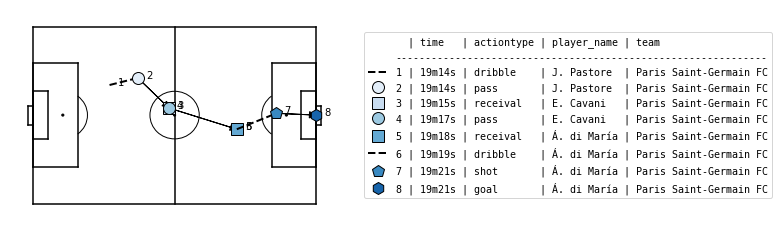

In [26]:
#select a goal to plot
import matplotsoccer

for shot in list(atomic_actions[(atomic_actions.type_name == "goal")][2:3].index):
    a = atomic_actions[shot-7:shot+1].copy()

    a["start_x"] = a.x
    a["start_y"] = a.y
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy

    g = game.iloc[0]
    minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
    game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}'"
    print(game_info)

    def nice_time(row):
        minute = int((row.period_id-1) * 45 + row.time_seconds // 60)
        second = int(row.time_seconds % 60)
        return f"{minute}m{second}s"

    a["nice_time"] = a.apply(nice_time,axis=1)
    labels = a[["nice_time", "type_name", "player_name", "team_name"]]

    matplotsoccer.actions(
        location=a[["start_x", "start_y", "end_x", "end_y"]],
        action_type=a.type_name,
        team= a.team_name,
        label=labels,
        labeltitle=["time", "actiontype", "player_name", "team"],
        zoom=False,
        figsize=6
    )

## Compute features and labels

In [27]:
features_h5 = os.path.join(datafolder, "atomic_features.h5")
labels_h5 = os.path.join(datafolder, "atomic_labels.h5")

In [28]:
games = pd.HDFStore(spadl_h5)['games']
print("nb of games:", len(games))

nb of games: 380


### Compute Probabilities

In [29]:
predictions_h5 = os.path.join(datafolder, "atomic-predictions-one-action.h5")

In [30]:
# 1. Select feature set X
xfns = [
    #fs.actiontype,
    fs.actiontype_onehot,
    #fs.bodypart,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta
]
nb_prev_actions = 3

Xcols = fs.feature_column_names(xfns, nb_prev_actions)

def getXY(games, Xcols):
    # generate the columns of the selected feature
    X = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting features"):
        Xi = pd.HDFStore(features_h5) [f"game_{game_id}"]
        X.append(Xi[Xcols])
    X = pd.concat(X).reset_index(drop=True)

    # 2. Select label Y
    Ycols = ["scores", "concedes"]
    Y = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting label"):
        Yi = pd.HDFStore(labels_h5)[f"game_{game_id}"]
        Y.append(Yi[Ycols])
    Y = pd.concat(Y).reset_index(drop=True)
    return X, Y

## Model 

In [31]:
### load model 
import pickle
model = pickle.load(open('trained_model.sav', 'rb'))

In [32]:
#Prediction per tutte le partite
gamesX, gamesY = getXY(games,Xcols)
Y_hat = pd.DataFrame()
for col in gamesY.columns:
    Y_hat[col] = [p[1] for p in model[col].predict_proba(gamesX)]

Selecting label: 100%|██████████| 380/380 [00:07<00:00, 48.84it/s]


In [33]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(games.game_id, "Loading actions of each game"):
    Ai = pd.HDFStore(spadl_h5) [f"actions/game_{game_id}"]
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, Y_hat], axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5, f"game_{int(k)}")

Saving predictions per game: 100%|██████████| 380/380 [00:11<00:00, 32.68it/s]


## VAEP

In [34]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 380


In [35]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Loading actions"):
    actions = pd.HDFStore(spadl_h5) [f"actions/game_{game.game_id}"]
    actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.HDFStore(predictions_h5) [f"game_{game.game_id}"]
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Loading actions: 100%|██████████| 380/380 [00:33<00:00, 11.18it/s]


Index(['game_id', 'original_event_id', 'action_id', 'period_id',
       'time_seconds', 'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id',
       'bodypart_id', 'type_name', 'bodypart_name', 'player_name', 'nickname',
       'team_name_short', 'team_name', 'scores', 'concedes', 'offensive_value',
       'defensive_value', 'vaep_value'],
      dtype='object')

In [36]:
#Df with players and roles
df_players = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/players.json')
df_players = df_players[['wyId','shortName','role','currentTeamId']]
Role = []
for i in range(len(df_players)):
    Role.append(df_players['role'][i]['name'])

df_players['Role'] = Role
df_players.drop('role', axis = 1,inplace = True)

df_players = pd.merge(df_players, teams, left_on = 'currentTeamId', right_on = 'team_id').drop(['currentTeamId','team_id','team_name'], axis = 1).rename(columns={'team_name_short':'Team'})

In [37]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR = pd.merge(playersR, df_players, left_on ='player_id', right_on = 'wyId', how = 'left').drop(['wyId','shortName'], axis = 1)
playersR["player_name"] = playersR[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name","Role","Team", "vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:20]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count
43,21174,E. Cavani,Forward,PSG,34.643425,33.784658,0.858768,1402
259,40810,Neymar,Forward,PSG,33.743305,32.522101,1.221204,3553
108,25770,F. Thauvin,Forward,Olympique Marseille,29.699657,29.140942,0.558714,4621
179,26365,B. Reynet,Goalkeeper,Dijon,26.803125,2.421194,24.381932,2942
3,118,M. Depay,Forward,Olympique Lyonnais,26.233523,25.600764,0.632759,3280
53,25410,A. Pléa,Forward,Nice,25.433299,23.515702,1.917597,2751
217,28115,N. Fekir,Midfielder,Olympique Lyonnais,25.427441,24.905791,0.521650,3133
19,5167,Mariano Díaz,Forward,Olympique Lyonnais,23.823555,23.229194,0.594361,1411
201,26638,K. Toko Ekambi,Forward,Angers,22.409896,22.061070,0.348826,2611
196,26583,R. Gurtner,Goalkeeper,Amiens SC,22.046398,1.964710,20.081687,2107


In [38]:
# Normalize for minutes played
pg = pd.HDFStore(spadl_h5) ["player_games"]
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 1200] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
258,40810,Neymar,Forward,PSG,33.743305,32.522101,1.221204,3553,1862,1.630987,1.571960,0.059027
42,21174,E. Cavani,Forward,PSG,34.643425,33.784658,0.858768,1402,2681,1.162965,1.134136,0.028828
2,118,M. Depay,Forward,Olympique Lyonnais,26.233523,25.600764,0.632759,3280,2671,0.883945,0.862624,0.021321
216,28115,N. Fekir,Midfielder,Olympique Lyonnais,25.427441,24.905791,0.521650,3133,2618,0.874129,0.856196,0.017933
107,25770,F. Thauvin,Forward,Olympique Marseille,29.699657,29.140942,0.558714,4621,3072,0.870107,0.853739,0.016369
473,353833,K. Mbappé,Forward,PSG,20.781155,20.249551,0.531604,2018,2255,0.829403,0.808186,0.021217
18,5167,Mariano Díaz,Forward,Olympique Lyonnais,23.823555,23.229194,0.594361,1411,2617,0.819305,0.798864,0.020440
13,3450,R. Falcao,Forward,Monaco,19.211458,18.988277,0.223181,1467,2212,0.781660,0.772579,0.009081
10,3314,Á. di María,Midfielder,PSG,17.896984,17.546573,0.350411,3006,2182,0.738189,0.723736,0.014453
386,256084,Kwon Chang-Hoon,Midfielder,Dijon,17.901105,16.615994,1.285111,1931,2239,0.719562,0.667905,0.051657


In [39]:
copy = stats.sort_values("vaep_rating",ascending=False)[:10].copy()
copy[['player_name','Role','Team','vaep_rating']]

,player_name,Role,Team,vaep_rating
258,Neymar,Forward,PSG,1.630987
42,E. Cavani,Forward,PSG,1.162965
2,M. Depay,Forward,Olympique Lyonnais,0.883945
216,N. Fekir,Midfielder,Olympique Lyonnais,0.874129
107,F. Thauvin,Forward,Olympique Marseille,0.870107
473,K. Mbappé,Forward,PSG,0.829403
18,Mariano Díaz,Forward,Olympique Lyonnais,0.819305
13,R. Falcao,Forward,Monaco,0.781660
10,Á. di María,Midfielder,PSG,0.738189
386,Kwon Chang-Hoon,Midfielder,Dijon,0.719562


In [40]:
stats.sort_values("defensive_rating",ascending=False)[:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
250,37896,E. Kawashima,NaN,NaN,21.004110,1.676434,19.327676,1508,2698,0.700656,0.055923,0.644733
178,26365,B. Reynet,Goalkeeper,Dijon,26.803125,2.421194,24.381932,2942,3595,0.671010,0.060614,0.610396
202,26676,A. Oukidja,Goalkeeper,Strasbourg,11.068882,0.569820,10.499062,819,1553,0.641468,0.033022,0.608445
73,25521,E. Zelazny,Goalkeeper,Troyes,10.537671,0.759700,9.777971,1086,1617,0.586512,0.042284,0.544228
307,134496,M. Maignan,Goalkeeper,Lille,19.558147,1.295133,18.263014,2075,3186,0.552490,0.036586,0.515904
195,26583,R. Gurtner,Goalkeeper,Amiens SC,22.046398,1.964710,20.081687,2107,3509,0.565453,0.050392,0.515062
130,25930,M. Samassa,Goalkeeper,Troyes,11.954006,0.871848,11.082157,1111,1993,0.539820,0.039371,0.500449
120,25845,S. Ruffier,Goalkeeper,Saint-\u00c9tienne,18.751720,1.343190,17.408530,1933,3163,0.533561,0.038219,0.495342
281,82690,T. Koubek,Goalkeeper,Rennes,16.315130,0.439987,15.875143,1657,3240,0.453198,0.012222,0.440976
87,25632,B. Costil,Goalkeeper,Bordeaux,18.528240,2.279154,16.249086,2001,3410,0.489015,0.060154,0.428862


In [41]:
copy = stats.sort_values("vaep_rating",ascending=False).copy()
copy[copy.Role == 'Goalkeeper'][['player_name','Role','Team','vaep_rating']][:10]

,player_name,Role,Team,vaep_rating
178,B. Reynet,Goalkeeper,Dijon,0.671010
202,A. Oukidja,Goalkeeper,Strasbourg,0.641468
73,E. Zelazny,Goalkeeper,Troyes,0.586512
195,R. Gurtner,Goalkeeper,Amiens SC,0.565453
307,M. Maignan,Goalkeeper,Lille,0.552490
130,M. Samassa,Goalkeeper,Troyes,0.539820
120,S. Ruffier,Goalkeeper,Saint-\u00c9tienne,0.533561
87,B. Costil,Goalkeeper,Bordeaux,0.489015
266,K. Johnsson,Goalkeeper,Guingamp,0.465033
45,A. Lopes,Goalkeeper,Olympique Lyonnais,0.459770


In [42]:
copy = stats.sort_values("vaep_rating",ascending=False).copy()
copy[copy.Role == 'Defender'][:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
249,37824,T. Meunier,Defender,PSG,10.920158,6.881904,4.038254,2509,1643,0.598183,0.376976,0.221207
440,300784,Jorge,Defender,Monaco,9.548380,6.053081,3.495299,2351,1991,0.431619,0.273620,0.157999
328,149101,A. Touré,Defender,Monaco,6.258531,2.814071,3.444460,1447,1309,0.430304,0.193481,0.236823
16,4452,Yuri Berchiche,Defender,PSG,8.070168,5.402269,2.667899,2467,1786,0.406671,0.272231,0.134441
367,231138,P. Kimpembe,Defender,PSG,11.099649,6.294346,4.805303,4032,2514,0.397362,0.225335,0.172028
36,20394,Thiago Silva,Defender,PSG,9.004967,6.766681,2.238286,3706,2198,0.368720,0.277071,0.091650
62,25457,J. Roussillon,Defender,Montpellier,7.851688,5.948955,1.902734,2249,1974,0.357980,0.271229,0.086751
97,25700,M. Debuchy,Defender,Saint-\u00c9tienne,5.321277,5.467071,-0.145794,1790,1375,0.348302,0.357845,-0.009543
347,215281,A. Mbengue,Defender,Caen,6.394438,4.448110,1.946328,1994,1663,0.346061,0.240728,0.105333
41,21097,K. Glik,Defender,Monaco,13.001269,5.338278,7.662991,4148,3389,0.345268,0.141766,0.203502


In [43]:
copy = stats.sort_values("vaep_rating",ascending=False).copy()
copy[copy.Role == 'Defender'][['player_name','Role','Team','vaep_rating']][:10]

,player_name,Role,Team,vaep_rating
249,T. Meunier,Defender,PSG,0.598183
440,Jorge,Defender,Monaco,0.431619
328,A. Touré,Defender,Monaco,0.430304
16,Yuri Berchiche,Defender,PSG,0.406671
367,P. Kimpembe,Defender,PSG,0.397362
36,Thiago Silva,Defender,PSG,0.368720
62,J. Roussillon,Defender,Montpellier,0.357980
97,M. Debuchy,Defender,Saint-\u00c9tienne,0.348302
347,A. Mbengue,Defender,Caen,0.346061
41,K. Glik,Defender,Monaco,0.345268


In [44]:
copy = stats.sort_values("vaep_rating",ascending=False).copy()
copy[copy.Role == 'Midfielder'][['player_name','Role','Team','vaep_rating']][:10]

,player_name,Role,Team,vaep_rating
216,N. Fekir,Midfielder,Olympique Lyonnais,0.874129
10,Á. di María,Midfielder,PSG,0.738189
386,Kwon Chang-Hoon,Midfielder,Dijon,0.719562
315,Rony Lopes,Midfielder,Monaco,0.677201
335,M. Sanson,Midfielder,Olympique Marseille,0.578923
143,R. Cabella,Midfielder,Saint-\u00c9tienne,0.534294
29,J. Draxler,Midfielder,PSG,0.530572
100,D. Payet,Midfielder,Olympique Marseille,0.513303
474,G. Lo Celso,Midfielder,PSG,0.512374
60,J. Pastore,Midfielder,PSG,0.504605


In [45]:
copy = stats.sort_values("vaep_rating",ascending=False).copy()
copy[copy.Role == 'Forward'][['player_name','Role','Team','vaep_rating']][:10]

,player_name,Role,Team,vaep_rating
258,Neymar,Forward,PSG,1.630987
42,E. Cavani,Forward,PSG,1.162965
2,M. Depay,Forward,Olympique Lyonnais,0.883945
107,F. Thauvin,Forward,Olympique Marseille,0.870107
473,K. Mbappé,Forward,PSG,0.829403
18,Mariano Díaz,Forward,Olympique Lyonnais,0.819305
13,R. Falcao,Forward,Monaco,0.781660
52,A. Pléa,Forward,Nice,0.718455
320,B. Traoré,Forward,Olympique Lyonnais,0.711685
23,M. Balotelli,Forward,Nice,0.677529


### Salary 

In [46]:
fra = pd.read_excel('/Users/leonardoyang/Desktop/Tesi/Data/ligue-1/2017-2018/all_ligue-1_2017-2018.xlsx')
fra = fra[fra['Annual Gross(IN EUR)']>0]
fra = fra.drop_duplicates(subset=["Player"], keep='last')
fra.drop('Unnamed: 0', axis = 1, inplace = True)

fra['Name'] = [fra['Player'][i-1:i].values[0].split()[0] for i in range(1,len(fra.Player)+1)]
fra['Surname'] = [fra['Player'][i-1:i].values[0].split()[-1] for i in range(1,len(fra.Player)+1)]
fra.head()
players['Name'] =[players['player_name'][i-1:i].values[0].split()[0] for i in range(1,len(players.player_name)+1)]
players['Surname'] =[players['player_name'][i-1:i].values[0].split()[-1] for i in range(1,len(players.player_name)+1)]
players.head()

giocatori = stats.merge(players, on = 'player_id').drop(['nickname'], axis = 1)
giocatori = giocatori[giocatori['minutes_played']>1500]

df = pd.merge(giocatori,fra, on = ['Name','Surname'], how = 'left').sort_values('Annual Gross(IN EUR)', ascending = False).rename(columns={'Annual Gross(IN EUR)':'Salary'})
df = df[['player_id','Player','Age','Role_x','Team_x','vaep_value','offensive_value','defensive_value','count','minutes_played','vaep_rating','Salary']]
missing = pd.merge(df,fra, left_on = 'player_id', right_on = 'ID')
missing = missing[['player_id','Player_y','Age_y','Role_x','Team_x','vaep_value','offensive_value','defensive_value','count','minutes_played','vaep_rating','Annual Gross(IN EUR)']]
missing.rename(columns={'Player_y':'Player','Age_y':'Age','Annual Gross(IN EUR)':'Salary'}, inplace = True)

df = pd.concat([df,missing]).rename(columns = {'Role_x':'Role','Team_x':'Team'}).reset_index(drop=True)
df = df.dropna().drop('player_id', axis = 1)
df['vaep/salary'] = df['vaep_value']*10**4/ df['Salary']
df[(df['Role']=='Forward')].sort_values('vaep/salary',ascending = False).groupby('Role').mean()

,Age,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,Salary,vaep/salary
Role,,,,,,,,,
Forward,23.95,14.177408,13.467057,0.710351,2122.925,2384.7,0.533576,3205150.0,0.137432


In [47]:
gk = df[df['Role']=='Goalkeeper'].sort_values('vaep/salary',ascending = False)[:5]
dif = df[df['Role']=='Defender'].sort_values('vaep/salary',ascending = False)[:5]
cen = df[df['Role']=='Midfielder'].sort_values('vaep/salary',ascending = False)[:5]
att = df[df['Role']=='Forward'].sort_values('vaep/salary',ascending = False)[:5]
top_11 = gk.append(dif).append(cen).append(att).sort_values(['Role','vaep_rating'],ascending = False)
top_11['Salary'] = top_11['Salary'].astype(int).map('{:,}'.format)
top_11[['Player','Age','Role','Team','vaep_rating','Salary','vaep/salary']]

,Player,Age,Role,Team,vaep_rating,Salary,vaep/salary
136,Flavien Tait,24.0,Midfielder,Angers,0.394393,"415,000",0.245822
158,Stéphane Darbion,33.0,Midfielder,Troyes,0.385993,"296,000",0.260516
140,Dimitri Liénard,29.0,Midfielder,Strasbourg,0.337259,"388,000",0.264823
179,Andrei Girotto,25.0,Midfielder,Nantes,0.236884,"98,000",0.430259
172,Thomas Monconduit,26.0,Midfielder,Amiens SC,0.236617,"237,000",0.342556
104,Baptiste Reynet,26.0,Goalkeeper,Dijon,0.671010,"533,000",0.502873
177,Erwin Zelazny,25.0,Goalkeeper,Troyes,0.586512,"157,000",0.671189
173,Régis Gurtner,30.0,Goalkeeper,Amiens SC,0.565453,"213,000",1.035042
160,Mamadou Samassa,27.0,Goalkeeper,Troyes,0.539820,"296,000",0.403852
151,Karl-Johan Johnsson,27.0,Goalkeeper,Guingamp,0.465033,"351,000",0.527891


In [48]:
display(fra[fra['Role']=='D'].sort_values('Annual Gross(IN EUR)',ascending = False)[:5])
display(fra[fra['Role']=='F'].sort_values('Annual Gross(IN EUR)',ascending = False)[:5])

,ID,Player,Annual Gross(IN EUR),Adj. Gross(IN EUR),Role,Age,Country,Team,League,Season,Name,Surname
488,NaN,Thiago Silva,15755000,16005510,D,32,Brazil,Psg,Ligue 1,2017-2018,Thiago,Silva
490,40539.0,Marquinhos,13173000,13382455,D,23,Brazil,Psg,Ligue 1,2017-2018,Marquinhos,Marquinhos
495,NaN,Layvin Kurzawa,5943000,6037496,D,24,France,Psg,Ligue 1,2017-2018,Layvin,Kurzawa
270,NaN,Aymen Abdennour,4953000,5031754,D,27,Tunisia,Marseille,Ligue 1,2017-2018,Aymen,Abdennour
235,NaN,Mapou Yanga-Mbiwa,3554000,3610510,D,28,France,Lyon,Ligue 1,2017-2018,Mapou,Yanga-Mbiwa


,ID,Player,Annual Gross(IN EUR),Adj. Gross(IN EUR),Role,Age,Country,Team,League,Season,Name,Surname
484,40810.0,Neymar,43300000,43988485,F,25,Brazil,Psg,Ligue 1,2017-2018,Neymar,Neymar
485,21174.0,Edinson Cavani,18243000,18533070,F,30,Uruguay,Psg,Ligue 1,2017-2018,Edinson,Cavani
486,353833.0,Kylian Mbappé,17769000,18051533,F,18,France,Psg,Ligue 1,2017-2018,Kylian,Mbappé
489,3314.0,Ángel Di María,13173000,13382455,F,29,Argentina,Psg,Ligue 1,2017-2018,Ángel,María
493,NaN,Julian Draxler,7108000,7221020,F,23,Germany,Psg,Ligue 1,2017-2018,Julian,Draxler


In [49]:
d = df[df['Role']=='Defender'].sort_values('Salary',ascending = False)[['Player','Age','Role','Team','vaep_rating','Salary','vaep/salary']][:5].reset_index(drop = True)
a = df[df['Role']=='Forward'].sort_values('Salary',ascending = False)[['Player','Age','Role','Team','vaep_rating','Salary','vaep/salary']][:5].reset_index(drop = True)
sal = pd.concat([d,a])
sal['Salary'] = sal['Salary'].astype(int).map('{:,}'.format)
sal

,Player,Age,Role,Team,vaep_rating,Salary,vaep/salary
0,Thiago Silva,32.0,Defender,PSG,0.368720,"15,755,000",0.005716
1,Marquinhos,23.0,Defender,PSG,0.256059,"13,173,000",0.005108
2,Layvin Kurzawa,24.0,Defender,PSG,0.234532,"5,943,000",0.007787
3,Adil Rami,31.0,Defender,Olympique Marseille,0.190977,"3,554,000",0.018557
4,Kamil Glik,29.0,Defender,Monaco,0.345268,"3,435,000",0.037849
0,Neymar,25.0,Forward,PSG,1.630987,"43,300,000",0.007793
1,Edinson Cavani,30.0,Forward,PSG,1.162965,"18,243,000",0.018990
2,Kylian Mbappé,18.0,Forward,PSG,0.829403,"17,769,000",0.011695
3,Mario Balotelli,26.0,Forward,Nice,0.677529,"5,331,000",0.033468
4,Florian Thauvin,24.0,Forward,Olympique Marseille,0.870107,"4,857,000",0.061148


# Plot

In [23]:
all_games = pd.DataFrame()
for game in tqdm.tqdm(games.game_id, desc="Loading actions"):
    actions = atomicspadl.add_names(pd.HDFStore(spadl_h5) [f"actions/game_{game}"])[['type_name','bodypart_name']]
    all_games = all_games.append(actions)

all_games = all_games.groupby('type_name').count().rename(columns = {'bodypart_name':'Count'}).sort_values('Count', ascending = False)

Loading actions: 100%|██████████| 380/380 [00:39<00:00,  9.70it/s]


In [24]:
all_games

,Count
type_name,
pass,316599
receival,275892
interception,84074
dribble,59801
out,19278
throw_in,17433
cross,11913
take_on,11440
freekick,11346


Text(0, 0.5, 'Action')

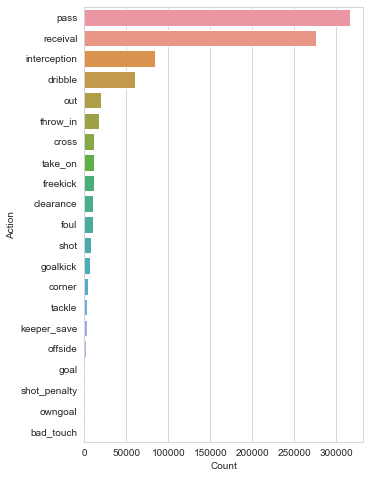

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
fig, axs = plt.subplots(figsize = (5,8))
sns.barplot(data = all_games, x = all_games.Count, y = all_games.index)
plt.ylabel('Action')